# Santander Customer Satisfaction

## Initialization

### Dependencies

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import random
from IPython.display import display
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

### Visualization Settings

In [2]:
%matplotlib inline
pd.options.display.float_format = '{:.6f}'.format
sns.set(style="white", color_codes=True)

### Files

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Overview

In [4]:
print(train.shape)
print(test.shape)
print(set(train.columns) - set(test.columns))

(76020, 371)
(75818, 370)
{'TARGET'}


In [5]:
n_customers = len(train)
n_unsatisfied = train.TARGET.sum()
n_satisfied = (train.TARGET==0).sum()
satisfaction_rate = float(n_satisfied)/n_customers

features = test.columns.drop('ID').tolist()
n_features = len(features)

print("Total number of customers: {}".format(n_customers))
print("Number of satisfied customers: {}".format(n_satisfied))
print("Number of unsatisfied customers: {}".format(n_unsatisfied))
print("Satisfaction rate: {:.2f}%".format(satisfaction_rate*100))
print("Number of features: {}".format(n_features))

Total number of customers: 76020
Number of satisfied customers: 73012
Number of unsatisfied customers: 3008
Satisfaction rate: 96.04%
Number of features: 369


In [6]:
if len(set(train.ID)) == len(train):
    print('No repeated ID')

No repeated ID


In [7]:
train_id = train.ID
test_id = test.ID
train.drop('ID', inplace=True, axis=1)
test.drop('ID', inplace=True, axis=1)

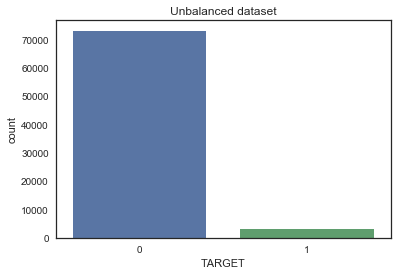

In [8]:
sns.countplot(train.TARGET);
plt.title('Unbalanced dataset');

In [9]:
target = train.TARGET
train.drop('TARGET', inplace=True, axis=1)

## Data Preparation

In [10]:
def replace_weird(dfs, weird = [-999999, 9999999999.00]):
    for df in dfs:
        modes = df.mode()
        for col in df.columns:
            if any([i in df[col].values for i in weird]):
#                 df['weird_'+col] = df[col].isin(weird)
                df[col].mask(df[col].isin(weird), modes[col][0], inplace=True)

replace_weird([train, test])

In [11]:
def remove_useless(dfs):
    remove = []
    for df in dfs:
        for col in df.columns:
            if df[col].std() == 0:
                remove.append(col)
    for df in dfs:
        df.drop(set(remove), axis=1, inplace=True)

remove_useless([train, test])

In [12]:
def duplicated(df):
    duplicated = []
    c = df.columns
    for i in range(len(c)-1):
        v = df[c[i]].values
        for j in range(i+1,len(c)):
            if np.array_equal(v,df[c[j]].values):
                duplicated.append(c[j])
    return set(duplicated)


duplicated_train = duplicated(train)
duplicated_test = duplicated(test)

if duplicated_test.issubset(duplicated_train):
    print('Duplicated columns on test set are also duplicated on training set.\
          \nAll duplicated being removed from both sets')
    train.drop(duplicated_train, axis=1, inplace=True)
    test.drop(duplicated_train, axis=1, inplace=True)

Duplicated columns on test set are also duplicated on training set.          
All duplicated being removed from both sets


In [13]:
train['ind_var10_cte_ult1'] = train['ind_var10cte_ult1']
test['ind_var10_cte_ult1'] = test['ind_var10cte_ult1']

train = train.drop(['ind_var10cte_ult1'], axis=1)
test = test.drop(['ind_var10cte_ult1'], axis=1)

In [14]:
features = test.columns.tolist()
n_features = len(features)
print(n_features)

292


## Exploring

In [15]:
def get_variable(s):
    return [i for i in s.split('_') if 'var' in i][0]

In [16]:
common_vars = Counter([get_variable(c) for c in train.select_dtypes('float').columns]).most_common(6)
common_vars

[('var13', 18),
 ('var44', 13),
 ('var17', 12),
 ('var33', 9),
 ('var40', 6),
 ('var39', 5)]

In [17]:
variables = list(set([get_variable(c) for c in train.columns]))
var_samples = [v[0] for v in common_vars]
cols_samples = [c for c in train.select_dtypes('float').columns if get_variable(c) in var_samples]

In [18]:
pca = PCA(2)
corr = train[cols_samples].corr()
corr = corr.reset_index()
corr['variable'] = corr['index'].apply(get_variable)
corr = corr.groupby('variable').sum().T

In [19]:
corr.head()

variable,var13,var17,var33,var39,var40,var44
imp_op_var39_comer_ult1,-0.091496,-0.009349,0.041839,3.106297,1.257799,0.065151
imp_op_var39_comer_ult3,-0.105383,-0.015975,0.047874,3.021855,1.274931,0.062068
imp_op_var40_comer_ult1,0.086057,0.033690,-0.006795,1.018762,3.493097,-0.003133
imp_op_var40_comer_ult3,0.072513,0.011480,-0.007530,0.940759,3.346345,-0.004127
imp_op_var40_efect_ult1,-0.013730,-0.000691,-0.000796,0.413933,2.626585,-0.001587


In [20]:
pca_data = pca.fit_transform(corr)
pca_data = pd.DataFrame(pca_data, columns = ['PCA Dimension 1', 'PCA Dimension 2'], index=corr.index)

In [21]:
pca_data.head()

,PCA Dimension 1,PCA Dimension 2
imp_op_var39_comer_ult1,-0.976697,-0.597967
imp_op_var39_comer_ult3,-0.981989,-0.598568
imp_op_var40_comer_ult1,-0.774900,-0.502379
imp_op_var40_comer_ult3,-0.765758,-0.506350
imp_op_var40_efect_ult1,-0.752256,-0.437745


In [22]:
pca_data = pca_data.reset_index()
pca_data['variable'] = pca_data['index'].apply(get_variable)
pca_data.head()

,index,PCA Dimension 1,PCA Dimension 2,variable
0,imp_op_var39_comer_ult1,-0.976697,-0.597967,var39
1,imp_op_var39_comer_ult3,-0.981989,-0.598568,var39
2,imp_op_var40_comer_ult1,-0.774900,-0.502379,var40
3,imp_op_var40_comer_ult3,-0.765758,-0.506350,var40
4,imp_op_var40_efect_ult1,-0.752256,-0.437745,var40


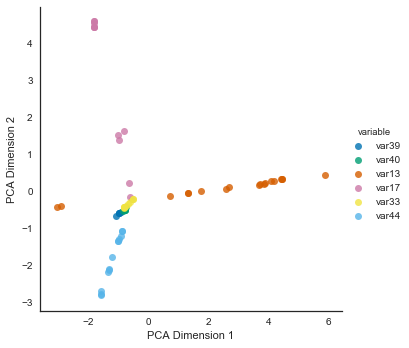

In [23]:
sns.lmplot(x="PCA Dimension 1", y="PCA Dimension 2", hue="variable", data=pca_data, fit_reg=False, palette='colorblind')

## Feature Engineering

### Extra Features

#### Values sum. "More money"

In [24]:
def values_sum(df):
    df['values_sum'] = df[features].sum(axis=1).astype(float)

values_sum(train)
values_sum(test)

#### Count zeros. "More products"

In [25]:
def count_zeros(df):
    zeros = (df.loc[:,features]==0).sum(axis=1).astype(float)
    df.loc[:,'zeros'] = zeros

count_zeros(train)
count_zeros(test)

#### Saldos

In [26]:
saldo_var_columns = [c for c in train.columns if 'saldo_var']
saldo_medio_hace2_columns = [c for c in train.columns if 'saldo_medio' in c and 'hace2' in c]
saldo_medio_hace3_columns = [c for c in train.columns if 'saldo_medio' in c and 'hace3' in c]
saldo_medio_ult1_columns = [c for c in train.columns if 'saldo_medio' in c and 'ult1' in c]
saldo_medio_ult3_columns = [c for c in train.columns if 'saldo_medio' in c and 'ult3' in c]

In [27]:
def sum_saldos(df):
    df['sum_of_saldos'] = df[saldo_var_columns].sum(axis=1)
    df['sum_of_saldo_medio_hace2'] = df[saldo_medio_hace2_columns].sum(axis=1)
    df['sum_of_saldo_medio_hace3'] = df[saldo_medio_hace3_columns].sum(axis=1)
    df['sum_of_saldo_medio_ult1'] = df[saldo_medio_ult1_columns].sum(axis=1)
    df['sum_of_saldo_medio_ult3'] = df[saldo_medio_ult3_columns].sum(axis=1)

sum_saldos(train)
sum_saldos(test)

#### VARs PCAs

In [28]:
def make_pca(df, var, var_cols, n):
    pca = PCA(n)
    pca_data = pca.fit_transform(df[var_cols])
    pca_cols =[var+'_pca_'+str(i+1) for i in range(n)]
    return (pd.DataFrame(pca_data, columns=pca_cols),
           pca.explained_variance_ratio_.sum())

def make_pcas(floats_only=True):
    train_pca = pd.DataFrame()
    test_pca = pd.DataFrame()

    df = pd.concat([train, test])
    if floats_only: df = df.select_dtypes('float')
    
    for var in variables:
        var_cols = [c for c in df.columns if var in c.split('_')]
        if not var_cols: continue
        n, e = (1,0)
        while e<0.95:
            _, e = make_pca(df, var, var_cols, n)
            train_pca_temp, _ = make_pca(train, var, var_cols, n)
            test_pca_temp, _ = make_pca(test, var, var_cols, n)
            n+=1
        train_pca = pd.concat([train_pca, train_pca_temp], axis=1)
        test_pca = pd.concat([test_pca, test_pca_temp], axis=1)
    return train_pca, test_pca
 
train_pca, test_pca = make_pcas()

In [29]:
extra_columns = ['values_sum','zeros','sum_of_saldos','sum_of_saldo_medio_hace2',
                 'sum_of_saldo_medio_hace3','sum_of_saldo_medio_ult1','sum_of_saldo_medio_ult3']

pca_columns = train_pca.columns.tolist()

train = pd.concat([train, train_pca], axis=1)
test = pd.concat([test, test_pca], axis=1)

#### Useful integers

In [30]:
useful_integers = []

for c in train.select_dtypes('int').columns:
    X_train, X_test, y_train, y_test = train_test_split(train.select_dtypes('float'),
                                                        train[c],
                                                        test_size = 0.25,
                                                        random_state=3)
    regressor = DecisionTreeRegressor(random_state=3)
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
#     print('{}: {}'.format(c, round(score,2)))
    if score<0.9: useful_integers.append(c)

In [31]:
train = train[pca_columns+extra_columns+useful_integers]
test = test[pca_columns+extra_columns+useful_integers]

## Feature Scaling

### Scaling PCA

In [32]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(pad.concat([train, test]).loc[:,pca_columns])
train[pca_columns] = pd.DataFrame(min_max_scaler.transform(train[pca_columns]), columns=pca_columns)
test[pca_columns] = pd.DataFrame(min_max_scaler.transform(test[pca_columns]), columns=pca_columns)

minimum_pca = min([train[pca_columns].replace(0,1).min().min()/2, test[pca_columns].replace(0,1).min().min()/2])
train[pca_columns] = train[pca_columns].replace(0,minimum_pca)
test[pca_columns] = test[pca_columns].replace(0,minimum_pca)
train[pca_columns] = train[pca_columns].apply(np.log)
test[pca_columns] = test[pca_columns].apply(np.log)

### Scaling extra columns

In [33]:
train[extra_columns].min()

values_sum                  7066.780000
zeros                        151.000000
sum_of_saldos              14396.560000
sum_of_saldo_medio_hace2    -287.670000
sum_of_saldo_medio_hace3      -8.040000
sum_of_saldo_medio_ult1    -3401.340000
sum_of_saldo_medio_ult3    -1844.520000
dtype: float64

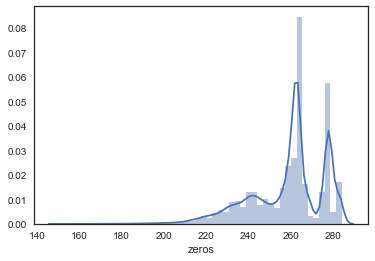

In [34]:
sns.distplot(train['zeros']);

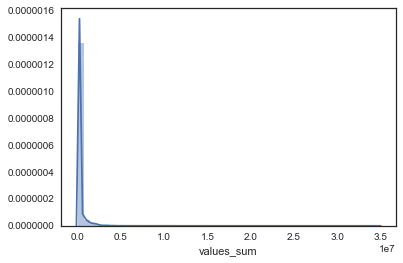

In [35]:
sns.distplot(train['values_sum']);

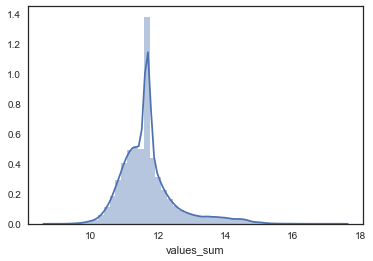

In [36]:
sns.distplot(train['values_sum'].apply(np.log));

In [37]:
train['values_sum'] = train['values_sum'].apply(np.log)
test['values_sum'] = test['values_sum'].apply(np.log)

#### Scaling Saldos

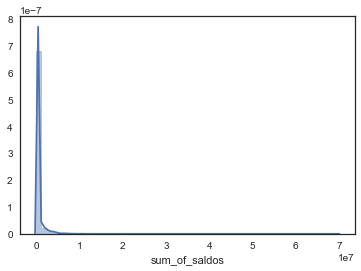

In [38]:
sns.distplot(train['sum_of_saldos']);

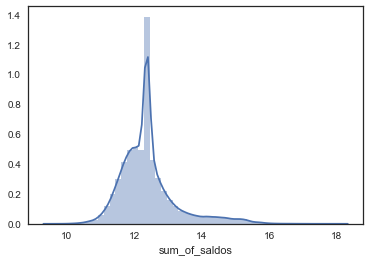

In [39]:
sns.distplot(train['sum_of_saldos'].apply(np.log));

In [40]:
saldos = ['sum_of_saldos', 'sum_of_saldo_medio_hace2', 'sum_of_saldo_medio_hace3', 'sum_of_saldo_medio_ult1', 'sum_of_saldo_medio_ult3']
min_saldo = min(train[saldos].min().min(), test[saldos].min().min())
max_saldo = max([train[saldos].max().max(), test[saldos].max().max()])
saldo_range = max_saldo - min_saldo

train[saldos] = train[saldos].apply(lambda x: (x - min_saldo) / saldo_range)
test[saldos] = test[saldos].apply(lambda x: (x - min_saldo) / saldo_range)

minimum_saldo = min([train[saldos].replace(0,1).min().min()/2, test[saldos].replace(0,1).min().min()/2])
train[saldos] = train[saldos].replace(0,minimum_saldo)
test[saldos] = test[saldos].replace(0,minimum_saldo)
train[saldos] = train[saldos].apply(np.log)
test[saldos] = test[saldos].apply(np.log)

### Feature Selection

#### Feature Importance

In [41]:
def get_feature_importances():
    from sklearn.ensemble import RandomForestClassifier
    rf_classifier = RandomForestClassifier(random_state=1, class_weight='balanced')

    n = len(train.columns)-1
    X = train
    y = target
    rf_classifier.fit(X, y)

    i_rf = rf_classifier.feature_importances_
    
    importances = pd.DataFrame({'i': i_rf}, index=train.columns)
    importances.sort_values('i', ascending=False, inplace=True)
    
    return importances

In [42]:
importances = get_feature_importances()

In [43]:
# most_important = importances.head(50).index
importances = importances[importances.i>0]
most_important = importances[importances.i>importances.i.mean()].index.tolist()
# most_important = importances[importances.i>0].index.tolist()
most_important = importances.head(50).index.tolist()

In [44]:
train = train[most_important]
test = test[most_important]

## Baselines

In [45]:
train.head()

,var15,values_sum,sum_of_saldos,var38_pca_1,sum_of_saldo_medio_ult1,var5_pca_1,zeros,sum_of_saldo_medio_hace3,sum_of_saldo_medio_ult3,var42_pca_1,...,var3,num_var30_0,var16_pca_2,var8_pca_3,num_var41_0,num_var35,num_aport_var13_hace3,num_op_var39_hace2,num_op_var39_comer_ult1,num_var39_0
0,23,10.580256,-6.879617,-6.629757,-9.929703,-5.994452,278.000000,-9.929703,-9.929703,-6.749122,...,2,3,-4.909839,-0.915162,3,0,0,0,0,3
1,34,10.851701,-6.620542,-6.395466,-9.856067,-5.987572,252.000000,-9.877326,-9.870187,-6.749122,...,2,6,-4.909839,-0.915162,3,3,3,0,0,3
2,23,11.120076,-6.361285,-6.077449,-9.928939,-5.992543,263.000000,-9.929657,-9.929176,-6.748515,...,2,3,-4.909839,-0.915162,3,3,0,0,0,3
3,37,11.099442,-6.381503,-6.128929,-9.906649,-5.912381,234.000000,-9.929703,-9.894949,-6.734934,...,2,3,-4.909839,-0.915162,3,9,0,0,9,3
4,39,14.068192,-3.442102,-5.515543,-6.430316,-3.692804,242.000000,-9.929627,-6.663262,-3.405693,...,2,6,-4.909839,-0.915162,3,3,0,0,0,3


In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

lr_baseline = LogisticRegression(class_weight= {0:0.2, 1:0.8})
rf_baseline = RandomForestClassifier(class_weight= 'balanced', max_depth=10)
xgb_baseline = XGBClassifier()

print(cross_val_score(lr_baseline, train, target, cv=3, scoring='roc_auc').mean())
print(cross_val_score(rf_baseline, train, target, cv=3, scoring='roc_auc').mean())
print(cross_val_score(xgb_baseline, train, target, cv=3, scoring='roc_auc').mean())

0.79091707944
0.814602680447
0.838330710024


## Parameter Optmization
### Grid Search

In [47]:
from sklearn.model_selection import GridSearchCV

#### Random Forest

In [48]:
rf_baseline

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [59]:
rf_clf = RandomForestClassifier(random_state=1, class_weight = 'balanced', n_estimators = 1000, n_jobs=-1)

rf_parameters = {'max_depth': [3, 5, 10, 20],
                 'min_samples_leaf': [1, 5, 50],
                 'min_samples_split': [2, 100, 1000, 3000], 
                 'n_estimators': [10, 100, 1000, 3000]}

rf_grid_obj = GridSearchCV(rf_clf, rf_parameters, scoring='roc_auc', verbose=1, cv=3)
rf_grid_obj = rf_grid_obj.fit(train, target)
rf_opt =  rf_grid_obj.best_estimator_
print(rf_grid_obj.best_score_)
rf_opt

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=1)]: Done 576 out of 576 | elapsed: 231.1min finished


0.8355764373111416


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=1000, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

#### XGBoost

In [60]:
xgb_baseline

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [73]:
xgb_clf = XGBClassifier(n_jobs=-1)
xgb_parameters = {'base_score': [0.1, 0.5],
                  'max_depth': [3, 6, 9],
                  'learning_rate': [0.01, 0.1],
                  'n_estimators': [100, 1000]}
                
xgb_grid_obj = GridSearchCV(xgb_clf, xgb_parameters, scoring='roc_auc', verbose=1, cv=3)

xgb_grid_obj = xgb_grid_obj.fit(train, target)
xgb_opt =  xgb_grid_obj.best_estimator_
print(xgb_grid_obj.best_score_)
xgb_opt

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 115.2min finished


0.8379826023928619


XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

In [94]:
xgb_clf = XGBClassifier(n_jobs=-1, silent=False, n_estimators=100)
xgb_parameters = {'base_score': [0.1, 0.5],
                  'max_depth': [3, 6],
                  'learning_rate': [0.01, 0.1]}
                
xgb_grid_obj = GridSearchCV(xgb_clf, xgb_parameters, scoring='roc_auc', verbose=1, cv=3)

xgb_grid_obj = xgb_grid_obj.fit(train, target)
xgb_opt =  xgb_grid_obj.best_estimator_
print(xgb_grid_obj.best_score_)
xgb_opt

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  6.0min finished


0.838330572643026


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

## Final model & Submission

In [126]:
model = xgb_opt
model.fit(train,target)
y_pred = model.predict_proba(test)[:,1]
train_estimates = model.predict_proba(train)[:,1]

In [127]:
estimates_df = pd.DataFrame({'pred':train_estimates, 'target': target})

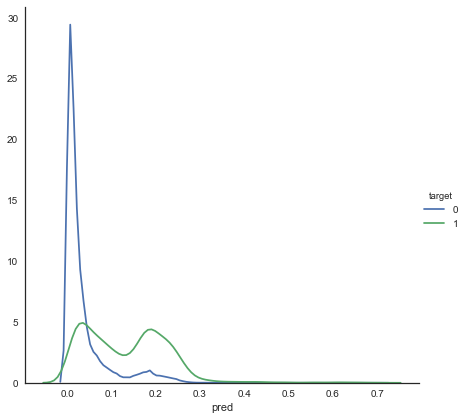

In [128]:
sns.FacetGrid(estimates_df, hue="target", size=6).map(sns.kdeplot, "pred").add_legend();

In [136]:
(estimates_df.loc[estimates_df.target==1].pred>0.05).mean()

0.746343085106383

In [99]:
def save_submission(prediction, name):
    sub = pd.DataFrame()
    sub['id'] = test_id
    sub['target'] = prediction
    sub.to_csv(name+'.csv', index=False)

In [100]:
save_submission(y_pred, 'xgb')
print('Predictions saved.')

Predictions saved.
